## Tutorial: External Compton scattering
In this tutorial we will show how to compute the Spectral Energy Distribution produced by Compton scattering by the blob electrons of three different photon targets: a Shakura Sunyaev accretion disk, a Broad Line region represented as a spherical shell and a Dust Torus represented as a simple ring.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import m_e, M_sun
from astropy.coordinates import Distance
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.emission_regions import Blob
from agnpy.compton import ExternalCompton
from agnpy.targets import SSDisk, SphericalShellBLR, RingDustTorus
from agnpy.utils.plot import plot_sed, load_mpl_rc

load_mpl_rc()

### Emission Region
In order to provide a cross-check with the literature, in this tutorial we will reproduce the results in Finke (2016) - [see bibliography in the docs](https://agnpy.readthedocs.io/en/latest/bibliography.html). Therefore we adapt an emission region with the same parameters specified in the paper. In this case we consider a broken power-law to describe the electron distribution.

In [3]:
# electron distribution and blob properties
R_b = 1e16 * u.cm
V_b = 4 / 3 * np.pi * R_b ** 3
z = 1
delta_D = 40
Gamma = 40
B = 0.56 * u.G

W_e = 6e42 * u.erg

n_e = BrokenPowerLaw.from_total_energy(
    W=W_e, V=V_b, p1=2.0, p2=3.5, gamma_b=1e4, gamma_min=20, gamma_max=5e7, mass=m_e
)

blob = Blob(R_b, z, delta_D, Gamma, B, n_e, gamma_e_size=500)

print(f"total number: {blob.N_e_tot:.2e}")
print(f"total energy: {blob.W_e:.2e}")

total number: 5.31e+46
total energy: 5.99e+42 erg


In [4]:
print(blob)

* Spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - t_var (variability time scale): 1.93e-01 d
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 1.00
 - d_L (source luminosity distance):2.10e+28 cm
 - delta_D (blob Doppler factor): 4.00e+01
 - Gamma (blob Lorentz factor): 4.00e+01
 - Beta (blob relativistic velocity): 1.00e+00
 - theta_s (jet viewing angle): 1.43e+00 deg
 - B (magnetic field tangled to the jet): 5.60e-01 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electrons energy distribution
 - broken power law
 - k: 2.54e-09 1 / cm3
 - p1: 2.00
 - p2: 3.50
 - gamma_b: 1.00e+04
 - gamma_min: 2.00e+01
 - gamma_max: 5.00e+07



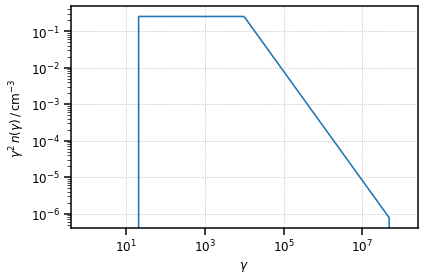

In [5]:
blob.n_e.plot(gamma_power=2)
plt.show()

### External Compton on Shakura Sunyaev Disk
The first result we reproduce is the SED generated by the External Compton (EC) scattering over a Shakura Sunyaev accretion disk, represented by the black lines in Figure 8. Different curves represent different distances between the emission region and the target.

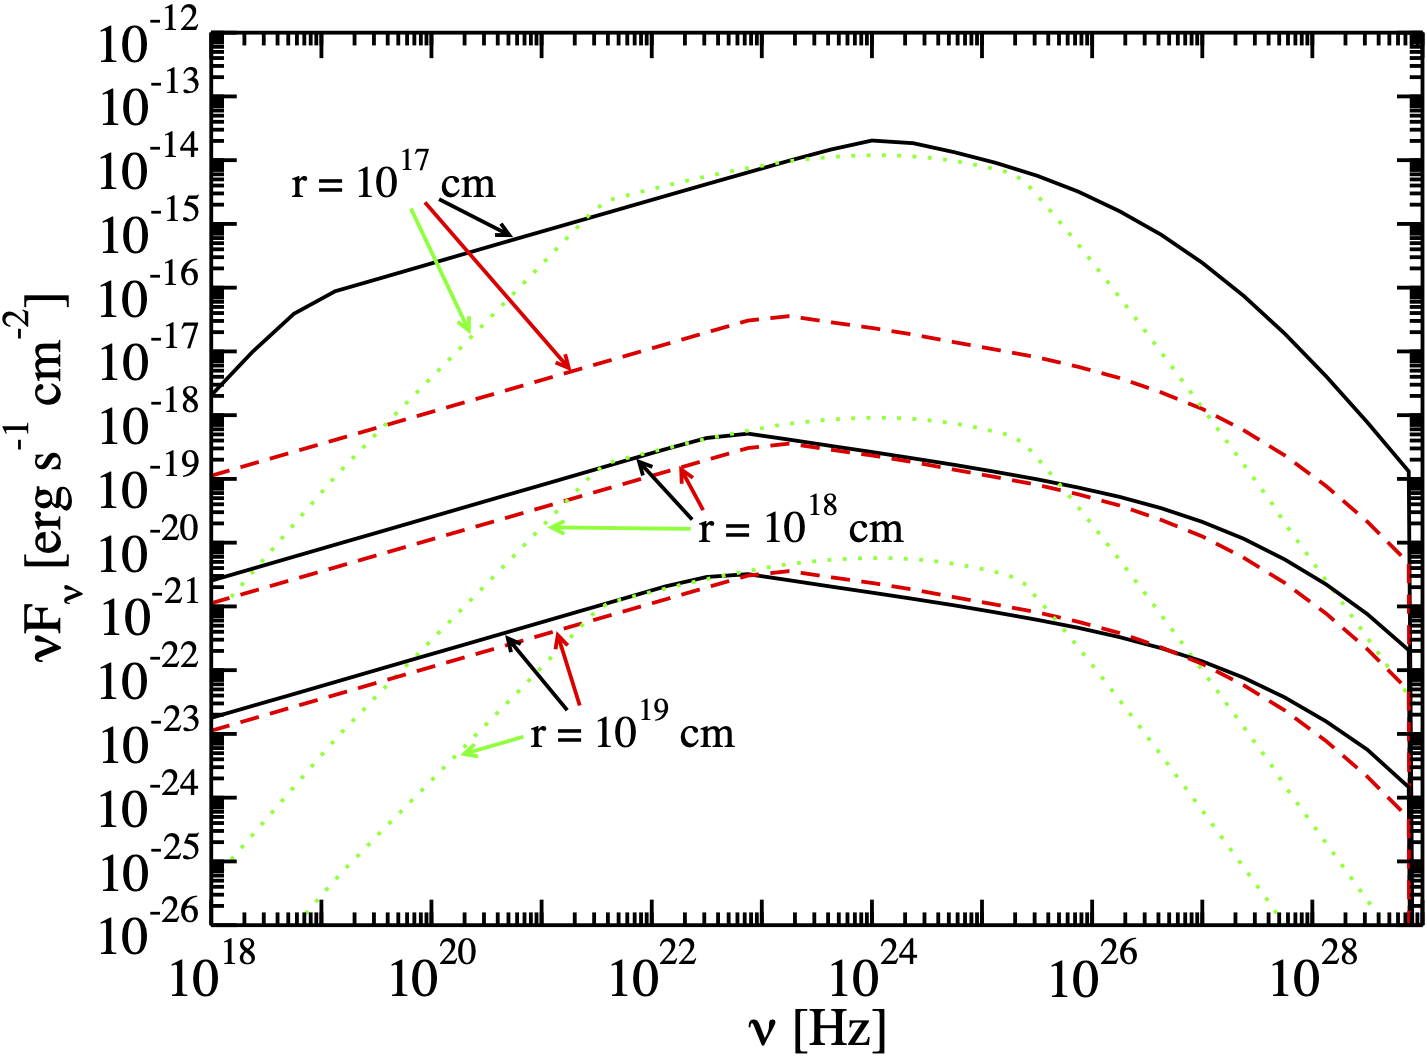

In [6]:
Image("figures/figure_8_finke_2016.png", width=600, height=400)

Let us start by defining an accretion disk around a Schwarzschild black hole of mass $1.2 \times 10^9 \, M_{\odot}$ (for an accretion disk around a Schwarzschild BH $\eta=1/12$, $R_{\rm in} = 6 R_g$, where $R_g$ is the gravitational radius).

In [7]:
# let us adopt the same disk parameters of Finke 2016
M_BH = 1.2 * 1e9 * M_sun.cgs
L_disk = 2 * 1e46 * u.Unit("erg s-1")
eta = 1 / 12
R_in = 6
R_out = 200
disk = SSDisk(M_BH, L_disk, eta, R_in, R_out, R_g_units=True)

In [8]:
print(disk)

* Shakura Sunyaev accretion disk:
 - M_BH (central black hole mass): 2.39e+42 g
 - L_disk (disk luminosity): 2.00e+46 erg / s
 - eta (accretion efficiency): 8.33e-02
 - dot(m) (mass accretion rate): 2.67e+26 g / s
 - R_in (disk inner radius): 1.06e+15 cm
 - R_out (disk inner radius): 3.54e+16 cm


Similarly to the synchrotron self-Compton case, to intitialise the object that will compute the  external Compton (EC) radiation, we simply pass the `Blob` and the `Target` objects to the `ExternalCompton` class. **Note** in this case the distance `r` between the target and the emission region (in `astropy.units`) also has to be specified, as this will modify the SED.

In [9]:
ec_disk_1 = ExternalCompton(blob, disk, r=1e17 * u.cm)
ec_disk_2 = ExternalCompton(blob, disk, r=1e18 * u.cm)
ec_disk_3 = ExternalCompton(blob, disk, r=1e19 * u.cm)

In [10]:
# define the array of frequencies over which to calculate the SED
nu = np.logspace(15, 30, 40) * u.Hz

In [11]:
# compute it
ec_disk_sed_1 = ec_disk_1.sed_flux(nu)
ec_disk_sed_2 = ec_disk_2.sed_flux(nu)
ec_disk_sed_3 = ec_disk_3.sed_flux(nu)

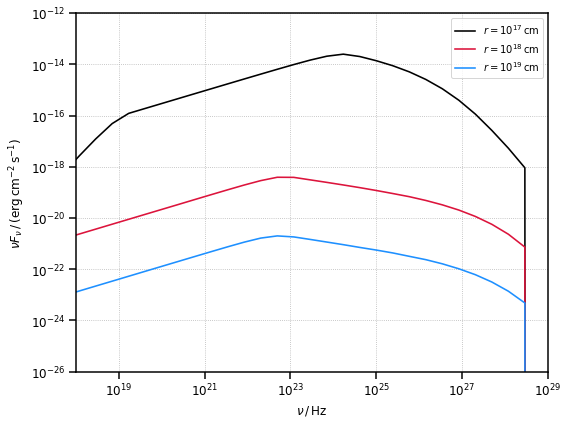

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_sed(nu, ec_disk_sed_1, ax=ax, color="k", label=r"$r=10^{17}\,{\rm cm}$")
plot_sed(nu, ec_disk_sed_2, ax=ax, color="crimson", label=r"$r=10^{18}\,{\rm cm}$")
plot_sed(nu, ec_disk_sed_3, ax=ax, color="dodgerblue", label=r"$r=10^{19}\,{\rm cm}$")

# set the same axis limits as in the reference figure
plt.xlim([1e18, 1e29])
plt.ylim([1e-26, 1e-12])
plt.show()

### External Compton Spherical Shell Broad Line Region
The second result we reproduce is the SED generated by the EC scattering over a Broad Line Region (BLR) modelled as an infinitesimally thin spherical shell, of radius $R_{\rm line}$, emitting only a sinlge spectral line, of dimensionless energy $\epsilon_{\rm line} = h \nu_{\rm line} / (m_e c^2)$. A fraction of the disk luminosity $\xi_{\rm line}$ is being reprocessed. The SEDs we aim to reproduce are represented by the black lines in Figure 10, with different curves representing different distances between the emission region and the target. 

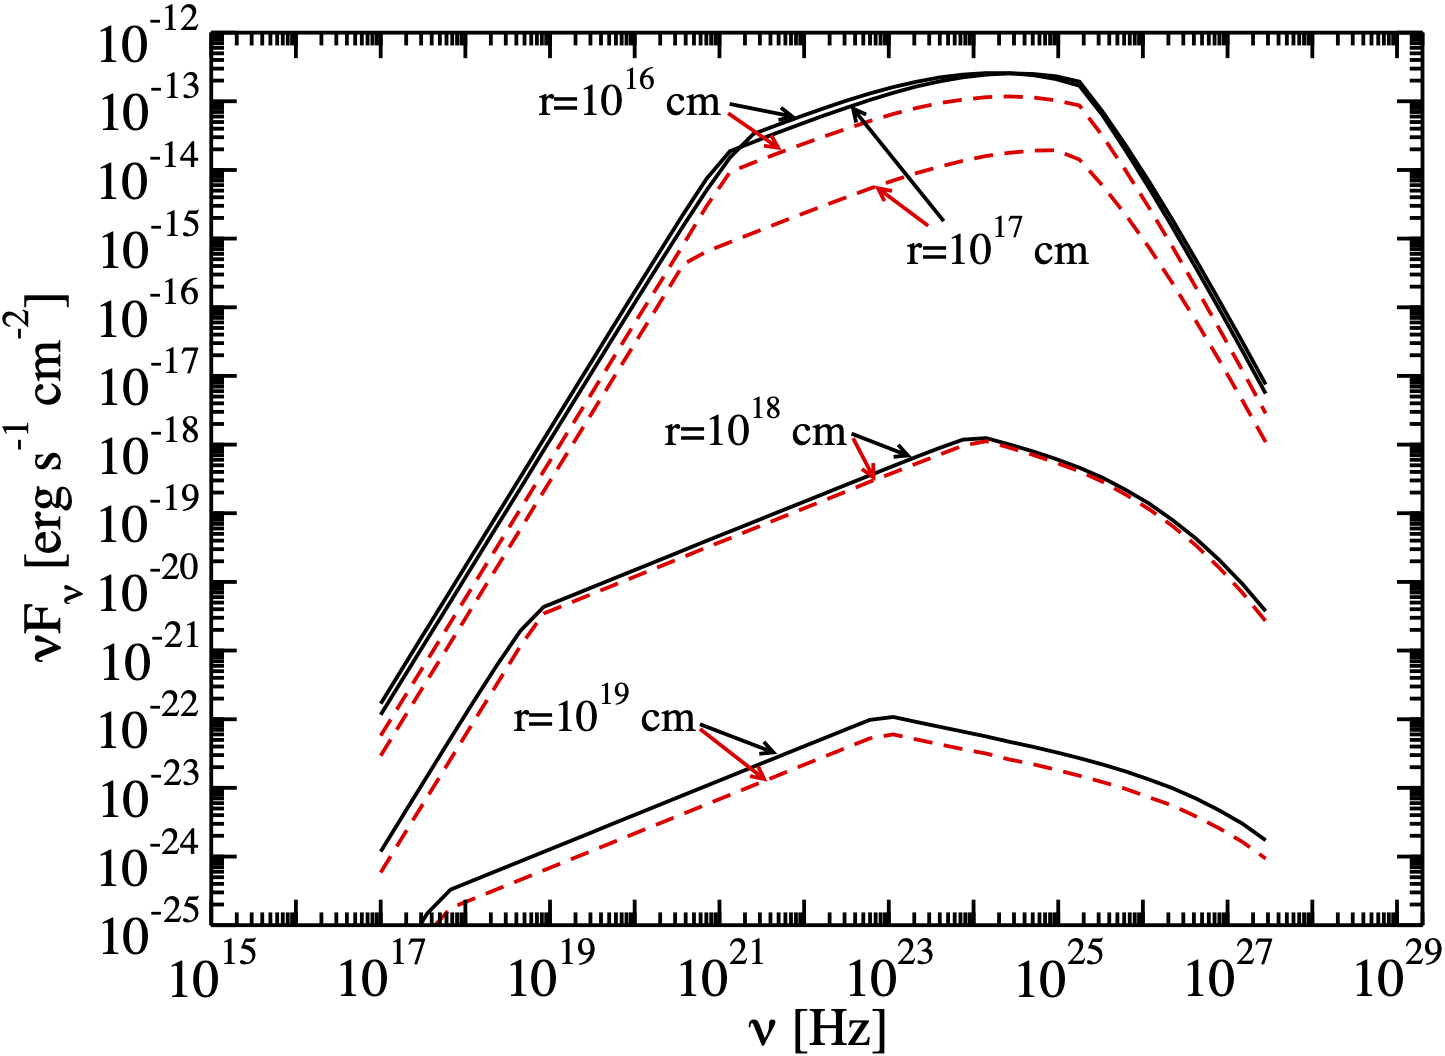

In [13]:
Image("figures/figure_10_finke_2016.png", width=600, height=400)

As in Finke 2016, let us consider a Spherical Shell Broad Line Region emitting the Lyman alpha line and reprocessing 2.4 % of the radiation from the disk defined above.

In [14]:
# BLR definition
xi_line = 0.024
R_line = 1e17 * u.cm
blr = SphericalShellBLR(L_disk, xi_line, "Lyalpha", R_line)

In [15]:
ec_blr_1 = ExternalCompton(blob, blr, r=1e16 * u.cm)
ec_blr_2 = ExternalCompton(blob, blr, r=1e18 * u.cm)
ec_blr_3 = ExternalCompton(blob, blr, r=1e19 * u.cm)

In [16]:
# compute the SEDs
ec_blr_sed_1 = ec_blr_1.sed_flux(nu)
ec_blr_sed_2 = ec_blr_2.sed_flux(nu)
ec_blr_sed_3 = ec_blr_3.sed_flux(nu)

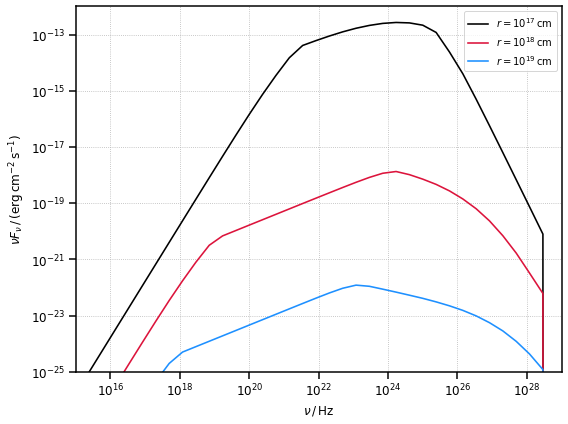

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_sed(nu, ec_blr_sed_1, ax=ax, color="k", label=r"$r=10^{17}\,{\rm cm}$")
plot_sed(nu, ec_blr_sed_2, ax=ax, color="crimson", label=r"$r=10^{18}\,{\rm cm}$")
plot_sed(nu, ec_blr_sed_3, ax=ax, color="dodgerblue", label=r"$r=10^{19}\,{\rm cm}$")

# set the same axis limits as in the reference figure
plt.ylim(1e-25, 1e-12)
plt.xlim(1e15, 1e29)
plt.show()

### External Compton Spherical Ring Dust Torus
The second result we reproduce is the SED generated by the EC scattering over a Dust Torus modelled as an infinitesimally thin ring of radius $R_{\rm dt}$. We approximate the target photons energy with the peak energy of the Dust Torus black body ($\epsilon_{\rm dt} = 2.7 k_B T / (m_e c^2)$). The Torus is reprocessing a fraction $\xi_{\rm dt}$ of the disk luminosity. The SEDs we aim to reproduce are represented by the black lines in Figure 11, with different curves representing different distances between the emission region and the target. 

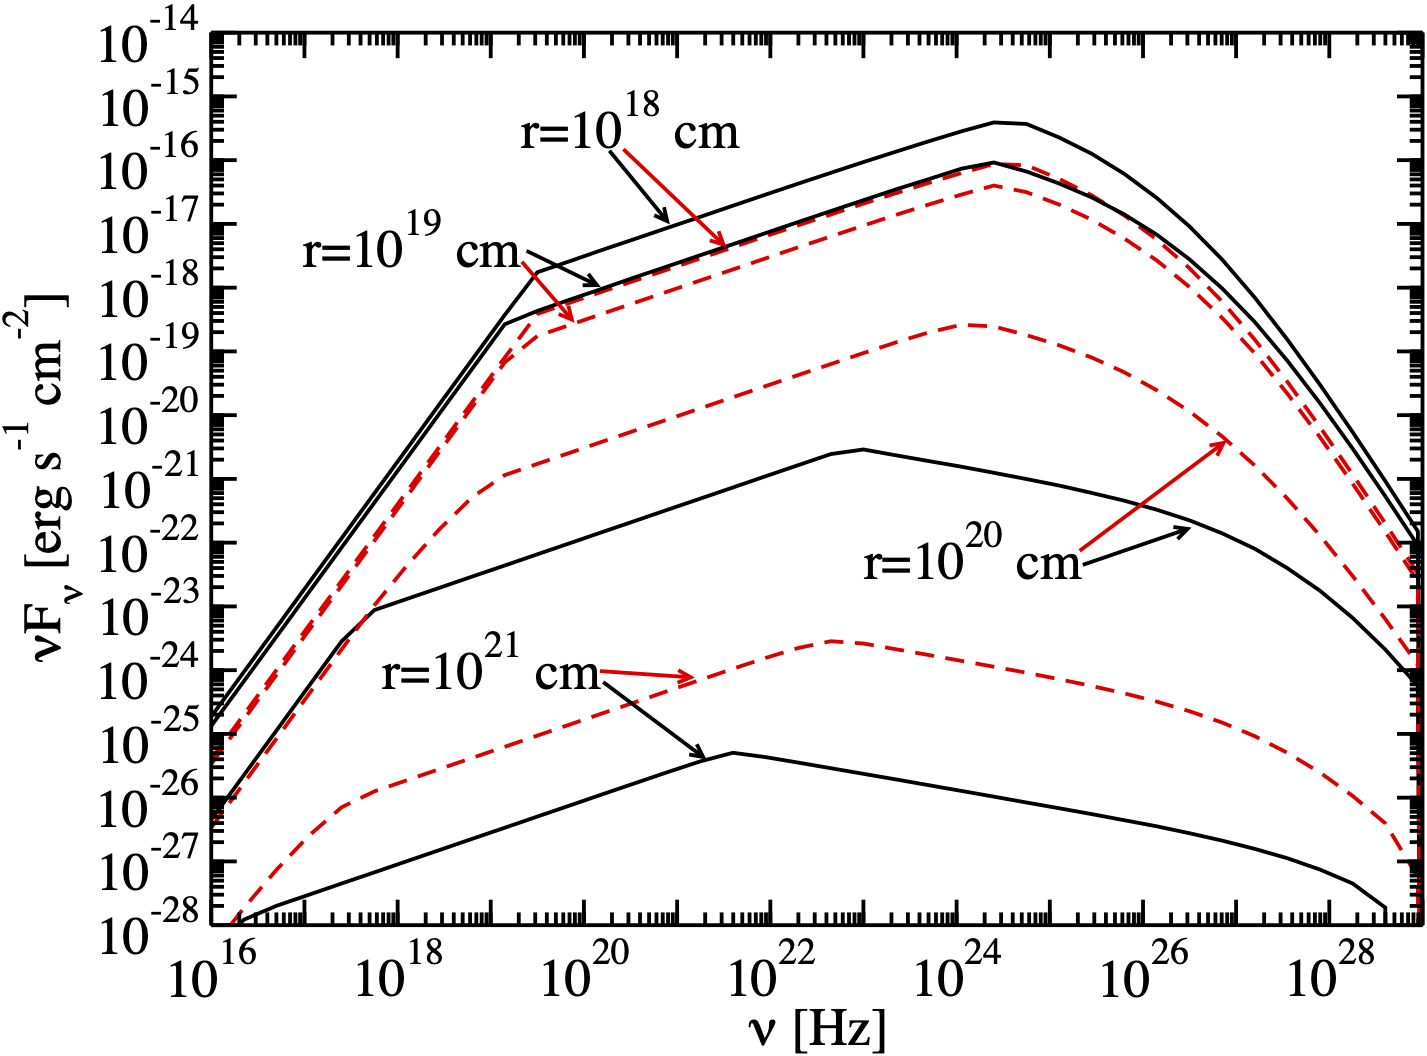

In [18]:
Image("figures/figure_11_finke_2016.png", width=600, height=400)

In [19]:
# dust torus definition
T_dt = 1e3 * u.K
csi_dt = 0.1
dt = RingDustTorus(L_disk, csi_dt, T_dt)

In [20]:
ec_dt_1 = ExternalCompton(blob, dt, r=1e19 * u.cm)
ec_dt_2 = ExternalCompton(blob, dt, r=1e20 * u.cm)
ec_dt_3 = ExternalCompton(blob, dt, r=1e21 * u.cm)

In [21]:
# compute the SEDs
ec_dt_sed_1 = ec_dt_1.sed_flux(nu)
ec_dt_sed_2 = ec_dt_2.sed_flux(nu)
ec_dt_sed_3 = ec_dt_3.sed_flux(nu)

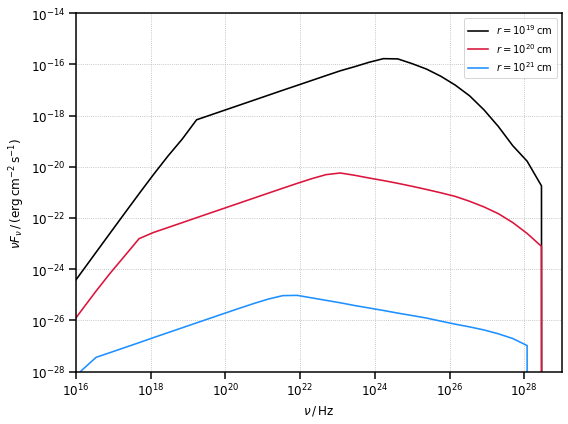

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_sed(nu, ec_dt_sed_1, ax=ax, color="k", label=r"$r=10^{19}\,{\rm cm}$")
plot_sed(nu, ec_dt_sed_2, ax=ax, color="crimson", label=r"$r=10^{20}\,{\rm cm}$")
plot_sed(nu, ec_dt_sed_3, ax=ax, color="dodgerblue", label=r"$r=10^{21}\,{\rm cm}$")

# set the same axis limits as in the reference figure
plt.ylim(1e-28, 1e-14)
plt.xlim(1e16, 1e29)
plt.show()